In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import random
import copy
import packages.baseline_model as baselibe_model
import packages.common_functions as common_functions
from skimage import io
import cv2
import packages.trans_in_rgb as trans_in_rgb
import matplotlib.pyplot as plt
import packages.CL_model as CL_model
from jpeg2dct.numpy import load, loads

2022-04-30 17:31:39.241844: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
class RGBProjectionHead(tf.keras.Model):
    """
    projection head for contrastive learning
    """

    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(512, bias_initializer=tf.keras.initializers.constant(0.01),
                                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                            bias_regularizer=regularizers.l2(1e-4))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(256, bias_initializer=tf.keras.initializers.constant(0.01),
                                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                            bias_regularizer=regularizers.l2(1e-4))
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, input, training=None):
        x = self.dense1(input)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        output = self.dense2(x)

        return output

In [3]:
class Resnet18_BaseEncoder(tf.keras.Model):

    def __init__(self, layer_params=None, method="late_concate"):
        super(Resnet18_BaseEncoder, self).__init__()

        self.method = method
        if layer_params is None:
            layer_params = [2, 2, 2, 2]
        self.y_input_bn = tf.keras.layers.BatchNormalization()
        self.cbcr_input_bn = tf.keras.layers.BatchNormalization()

        self.layer1_y = make_basic_block_layer(filter_num=64,
                                             blocks=1, dimen_match=True) # y:56,56,64
        self.cb2_y = make_basic_block_layer(filter_num=128,
                                             blocks=1, stride=2) # y:28,28,128
        self.cb2_cbcr = tf.keras.layers.Conv2D(filters=128,
                                               kernel_size=(1,1),
                                               strides=1,
                                               padding="same")
        self.cb_bn = tf.keras.layers.BatchNormalization()
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=2, # 14,14,512
                                             stride=2)
        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.flatten = tf.keras.layers.Flatten()

    def call(self, inputs, training=None, mask=None):
        y = self.y_input_bn(inputs[0], training=training)
        cb_cr = self.cbcr_input_bn(inputs[1], training=training)

        y = self.layer1_y(y, training=training) # 56,56,64
        y = self.cb2_y(y, training=training) # 28,28,128
        cb_cr = tf.nn.relu(self.cb_bn(self.cb2_cbcr(cb_cr), training=training)) #28,28,128
        x = tf.concat((y, cb_cr), axis=3) #28,28,256
        x = self.layer4(x, training=training) #14,14,512
        x = self.avgpool(x)
        output = self.flatten(x)

        return output


def make_basic_block_layer(filter_num, blocks, k_size=(3,3), stride=1, dimen_match=False):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, k_size=k_size, stride=stride, dimen_match=dimen_match))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, k_size=(3,3), stride=1, dimen_match=False):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=k_size,
                                            strides=stride,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=k_size,
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1 or dimen_match is True:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

In [4]:
# Define hyper parameters
batch_size = 128
tau = 0.1

# Define base encoder and projection head
feature_extractor = Resnet18_BaseEncoder()
projection_head = RGBProjectionHead()

# Define optimizers for contrastive learning
pic_num_list = np.load("/home/ldu/CL_gaze_project/Pretrain_subject/pic_num_list.npy")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
subject_num = 70


# define batch for query and positive
query_batch_y = np.zeros((batch_size, 28, 28, 6))
query_batch_cbcr = np.zeros((batch_size, 14, 14, 6))
positive_batch_y = np.zeros((batch_size, 28, 28, 6))
positive_batch_cbcr = np.zeros((batch_size, 14, 14, 6))

trans_list = [1, 2]
error_list = np.zeros((70,1))
error_list = error_list.tolist()

2022-04-30 17:31:44.281020: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-30 17:31:44.282921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-30 17:31:44.326797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 17:31:44.327465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-04-30 17:31:44.327490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-30 17:31:44.329486: I tensorflow/stream_executor/platform/defau

In [16]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
# contrastive learning
for epoch in range(100):

    subject_index = np.random.choice(subject_num, subject_num, replace=False)
    episode = 0
    for sub in subject_index:
        index = np.random.choice(pic_num_list[sub], batch_size, replace=False)
        j = 0
        for i in index:
            jpeg_file = '/home/ldu/CL_gaze_project/Pretrain_subject/' + str(sub) + '/' + str(i) + '.jpg'
            img = io.imread(jpeg_file) / 255.
            selected_trans = random.sample(trans_list, 2)
            noised_image1 = trans_in_rgb.apply_transformation(copy.deepcopy(img), selected_trans[0])
            noised_image2 = trans_in_rgb.apply_transformation(copy.deepcopy(img), selected_trans[1])

            noised_image1 = trans_in_rgb.apply_transformation(copy.deepcopy(noised_image1), selected_trans[1])
            noised_image2 = trans_in_rgb.apply_transformation(copy.deepcopy(noised_image2), selected_trans[0])
            
            noised_image1 = cv2.resize(noised_image1, (224,224))
            noised_image2 = cv2.resize(noised_image2, (224,224))

            noised_image1 *= 255
            noised_image1 = np.round(noised_image1).astype(np.uint8)
            noised_image2 *= 255
            noised_image2 = np.round(noised_image2).astype(np.uint8)
            io.imsave("/home/ldu/CL_gaze_project/temp_pic_0/noised_image1.jpg", noised_image1)
            io.imsave("/home/ldu/CL_gaze_project/temp_pic_0/noised_image2.jpg", noised_image2)

            jpeg_noised = "/home/ldu/CL_gaze_project/temp_pic_0/noised_image1.jpg"
            dct_y, dct_cb, dct_cr = load(jpeg_noised)
            # channel selection
            dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                    np.reshape(dct_y[:, :, 16], (28, 28, 1))), axis=2)

            dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (14, 14, 1))), axis=2)
            dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (14, 14, 1))), axis=2)
            cb_cr = np.concatenate([dct_cb, dct_cr], 2)
            query_batch_y[j, :, :, :] = dct_y
            query_batch_cbcr[j, :, :, :] = cb_cr

            jpeg_noised = "/home/ldu/CL_gaze_project/temp_pic_0/noised_image2.jpg"
            dct_y, dct_cb, dct_cr = load(jpeg_noised)
            # channel selection
            dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                    np.reshape(dct_y[:, :, 16], (28, 28, 1))), axis=2)

            dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (14, 14, 1))), axis=2)
            dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (14, 14, 1))), axis=2)
            cb_cr = np.concatenate([dct_cb, dct_cr], 2)
            positive_batch_y[j, :, :, :] = dct_y
            positive_batch_cbcr[j, :, :, :] = cb_cr

            j += 1

        with tf.GradientTape() as tape:

            x1_feature = tf.math.l2_normalize(projection_head(feature_extractor([query_batch_y, query_batch_cbcr], training=True), training=True), axis=1)
            x2_feature = tf.math.l2_normalize(projection_head(feature_extractor([positive_batch_y, positive_batch_cbcr], training=True), training=True), axis=1)

            x1_x2_mat = tf.exp(tf.matmul(x1_feature, tf.transpose(x2_feature)) / tau)

            denominator = tf.reduce_sum(x1_x2_mat, 1)
            #positive_sim = tf.linalg.diag_part(x1_x2_mat)
            prob = x1_x2_mat / tf.reshape(denominator, (x1_feature.shape[0], 1))
            prob = tf.linalg.diag_part(prob)

            loss = -tf.reduce_mean(tf.math.log(prob))

        grads = tape.gradient(loss, feature_extractor.trainable_variables + projection_head.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, feature_extractor.trainable_variables + projection_head.trainable_variables))
        episode += 1
        error_list[sub].append(loss.numpy())
        if episode % 5 == 0:
            print("current epoch: ", epoch, "current episode", episode, "current loss", loss.numpy())

/tmp/ipykernel_7917/1914252325.py:27: UserWarning: /home/ldu/CL_gaze_project/temp_pic_0/noised_image1.jpg is a low contrast image
  io.imsave("/home/ldu/CL_gaze_project/temp_pic_0/noised_image1.jpg", noised_image1)
/tmp/ipykernel_7917/1914252325.py:28: UserWarning: /home/ldu/CL_gaze_project/temp_pic_0/noised_image2.jpg is a low contrast image
  io.imsave("/home/ldu/CL_gaze_project/temp_pic_0/noised_image2.jpg", noised_image2)


current epoch:  0 current episode 5 current loss 0.45772427
current epoch:  0 current episode 10 current loss 0.40635806
current epoch:  0 current episode 15 current loss 0.31099862
current epoch:  0 current episode 20 current loss 0.55886304
current epoch:  0 current episode 25 current loss 0.4520669
current epoch:  0 current episode 30 current loss 0.62375194
current epoch:  0 current episode 35 current loss 0.5726638
current epoch:  0 current episode 40 current loss 0.64872634
current epoch:  0 current episode 45 current loss 0.66990083
current epoch:  0 current episode 50 current loss 0.32806996
current epoch:  0 current episode 55 current loss 0.6045792
current epoch:  0 current episode 60 current loss 0.5859667
current epoch:  0 current episode 65 current loss 0.5371083
current epoch:  0 current episode 70 current loss 0.43211877
current epoch:  1 current episode 5 current loss 0.54700387
current epoch:  1 current episode 10 current loss 0.66088873
current epoch:  1 current episo

KeyboardInterrupt: 

/tmp/ipykernel_7917/1178378646.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  error_list_arr= np.array(error_list)


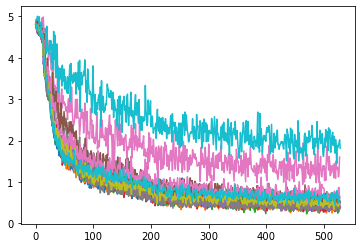

In [17]:
error_list_arr= np.array(error_list)
for sub_fig in range(20):
    plt.plot(error_list_arr[sub_fig][1:-1])

In [ ]:
plt.plot(error_list)

In [18]:
#feature_extractor.save_weights("/home/ldu/CL_gaze_project/dct_subject_late_concat_simple_input224_res18/base_1")
#projection_head.save_weights("/home/ldu/CL_gaze_project/dct_subject_late_concat_simple_input224_res18/pro_1")

In [40]:
feature_extractor.load_weights("/home/ldu/CL_gaze_project/dct_subject_late_concat_simple_input224_res18/base_1")
projection_head.load_weights("/home/ldu/CL_gaze_project/dct_subject_late_concat_simple_input224_res18/pro_1")

In [41]:
labels_per = np.load("/home/ldu/CL_gaze_project/Personalize/subject0102/labels.npy")
GazeEstimation = CL_model.GazeEstimationHead()
GazeEstimation.load_weights("/home/ldu/CL_gaze_project/dct_mix_late_concat_new_structure/Gaze_1")
data_size = labels_per.shape[0]
print(data_size)

optimizer_per = tf.keras.optimizers.Adam(learning_rate=.0025, decay=0.0005)

train_error_per = []
val_error_per = []
test_error_per = []

total_index = np.load("/home/ldu/CL_gaze_project/Personalize/subject0102/random_index.npy")
train_index = total_index[75: 150]
val_index = total_index[0: 25]
test_index = np.concatenate((total_index[25:75],total_index[150: data_size]),0)
#print(train_index)

573


In [42]:
optimizer_per = tf.keras.optimizers.Adam(learning_rate=.005)
for epoch in range(3000):
    j = 0
    mini_batch_y = np.zeros((train_index.shape[0], 56, 56, 6))
    mini_batch_cbcr = np.zeros((train_index.shape[0], 28, 28, 6))
    for i in train_index:
        jpeg_file = '/home/ldu/CL_gaze_project/Personalize/subject0102/' + str(i) + '.jpg'
        dct_y, dct_cb, dct_cr = load(jpeg_file)
        # channel selection
        dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                np.reshape(dct_y[:, :, 16], (56, 56, 1))), axis=2)

        dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (28, 28, 1))), axis=2)
        dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (28, 28, 1))), axis=2)
        cb_cr = np.concatenate([dct_cb, dct_cr], 2)
        #cb_cr = np.repeat(np.repeat(cb_cr, 2, 0), 2, 1)
        #img = cv2.resize(img, (224,224))
        mini_batch_y[j, :, :, :] = dct_y
        mini_batch_cbcr[j, :, :, :] = cb_cr
        j += 1

    # optimization
    with tf.GradientTape() as tape:
        prediction = GazeEstimation(feature_extractor([mini_batch_y, mini_batch_cbcr]))
        loss = tf.reduce_mean(tf.square(labels_per[train_index] - prediction))
        #GazeEstimation.save_weights("/home/ldu/CL_gaze_project/dct_mix_late_concat_new_structure/Gaze_2")
        #print(loss.numpy())

    grads = tape.gradient(loss, GazeEstimation.trainable_variables)
    optimizer_per.apply_gradients(grads_and_vars=zip(grads, GazeEstimation.trainable_variables))

    # training error

    train_angle_error = common_functions.avg_angle_error(prediction, labels_per[train_index])
    train_error_per.append(train_angle_error.numpy())

    # validation error
    if epoch % 5 == 0:
        j = 0
        mini_batch_y = np.zeros((val_index.shape[0], 56, 56, 6))
        mini_batch_cbcr = np.zeros((val_index.shape[0], 28, 28, 6))
        for i in val_index:
            jpeg_file = '/home/ldu/CL_gaze_project/Personalize/subject0102/' + str(i) + '.jpg'
            dct_y, dct_cb, dct_cr = load(jpeg_file)
            # channel selection
            dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                    np.reshape(dct_y[:, :, 16], (56, 56, 1))), axis=2)

            dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (28, 28, 1))), axis=2)
            dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (28, 28, 1))), axis=2)
            cb_cr = np.concatenate([dct_cb, dct_cr], 2)
            #cb_cr = np.repeat(np.repeat(cb_cr, 2, 0), 2, 1)
            #img = cv2.resize(img, (224,224))
            mini_batch_y[j, :, :, :] = dct_y
            mini_batch_cbcr[j, :, :, :] = cb_cr
            j += 1
        prediction = GazeEstimation(feature_extractor([mini_batch_y, mini_batch_cbcr]))
        validation_angle_error = common_functions.avg_angle_error(prediction, labels_per[val_index])

        print("epoch: ", epoch, "loss", loss.numpy(), "train", train_angle_error.numpy(),
              "validation", validation_angle_error.numpy())
        val_error_per.append(validation_angle_error.numpy())
    # test
    if epoch % 5 == 0:
        batch_number = 5
        test_error = 0.
        for batch_i in range(batch_number):
            start = batch_i * 100
            end = (batch_i + 1) * 100
            if end >= test_index.shape[0]:
                end = test_index.shape[0]
            test_batch_y = np.zeros((test_index[start: end].shape[0], 56, 56, 6))
            test_batch_cbcr = np.zeros((test_index[start: end].shape[0], 28, 28, 6))
            j = 0
            for i in test_index[start: end]:
                jpeg_file = '/home/ldu/CL_gaze_project/Personalize/subject0102/' + str(i) + '.jpg'
                dct_y, dct_cb, dct_cr = load(jpeg_file)
                # channel selection
                dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                                        np.reshape(dct_y[:, :, 16], (56, 56, 1))), axis=2)

                dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (28, 28, 1))), axis=2)
                dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (28, 28, 1))), axis=2)
                cb_cr = np.concatenate([dct_cb, dct_cr], 2)
                #cb_cr = np.repeat(np.repeat(cb_cr, 2, 0), 2, 1)
                #img = cv2.resize(img, (224,224))
                test_batch_y[j, :, :, :] = dct_y
                test_batch_cbcr[j, :, :, :] = cb_cr
                j += 1
            prediction = GazeEstimation(feature_extractor([test_batch_y, test_batch_cbcr]))
            test_error += common_functions.avg_angle_error(prediction, labels_per[test_index[start: end]]) \
                          * test_index[start: end].shape[0]
        test_error_per.append(test_error.numpy() / test_index.shape[0])
        print("epoch:", epoch, "test error:", test_error.numpy() / test_index.shape[0])

epoch:  0 loss 0.2316558 train 35.130281433666156 validation 127.6271545207371
epoch: 0 test error: 130.4741518576514
epoch:  5 loss 2.1227992 train 98.90245894943652 validation 77.85734074073439
epoch: 5 test error: 73.82085757939704
epoch:  10 loss 0.0945562 train 22.837636818957073 validation 24.05441477017171
epoch: 10 test error: 24.939713033927053
epoch:  15 loss 0.123295024 train 24.89534027886137 validation 24.648369804737982
epoch: 15 test error: 26.385454130259717
epoch:  20 loss 0.11329956 train 23.34055418570159 validation 22.753997523070044
epoch: 20 test error: 24.305006592387326
epoch:  25 loss 0.081804514 train 20.385454838181317 validation 20.862961395259482
epoch: 25 test error: 21.38355490785494
epoch:  30 loss 0.058674343 train 17.42190329960698 validation 19.72154508145429
epoch: 30 test error: 18.015524655078003
epoch:  35 loss 0.04895277 train 15.32629001849787 validation 17.58209407832409
epoch: 35 test error: 15.93556437114065
epoch:  40 loss 0.037946805 train 

In [16]:
# test inference time
import time
test_y = np.zeros((1, 56, 56, 6))
test_cbcr = np.zeros((1, 28, 28, 6))
jpeg_file = '/home/ldu/CLAE_Advdrop/Personalize/subject0102/1.jpg'
t0 = time.perf_counter()
for _ in range(100):
    dct_y, dct_cb, dct_cr = load(jpeg_file)
        # channel selection
    dct_y = np.concatenate((np.concatenate((dct_y[:, :, 0:3], dct_y[:, :, 8:10]), axis=2),
                            np.reshape(dct_y[:, :, 16], (56, 56, 1))), axis=2)

    dct_cb = np.concatenate((dct_cb[:, :, 0:2], np.reshape(dct_cb[:, :, 8], (28, 28, 1))), axis=2)
    dct_cr = np.concatenate((dct_cr[:, :, 0:2], np.reshape(dct_cr[:, :, 8], (28, 28, 1))), axis=2)
    cb_cr = np.concatenate([dct_cb, dct_cr], 2)
    test_y[0, :, :, :] = dct_y
    test_cbcr[0, :, :, :] = cb_cr
    pre = GazeEstimation(feature_extractor([test_y, test_cbcr]))
t1 = time.perf_counter()
print('processing time',(t1-t0)/100)

processing time 0.01410609444603324


In [12]:
A = np.array([[0.299, 0.587, 0.114], [-0.169, -0.331, 0.5], [0.5, -0.419, -0.081]])


def calculate_dct_coeff(img_local):

    img_local.astype(float)
    row_after_dct = int(img_local.shape[0] / 8)
    col_after_dct = int(img_local.shape[1] / 8)
    dct_coefficients = np.zeros((row_after_dct, col_after_dct, 64))

    # calculate dct coefficients for each block
    for i in range(row_after_dct):
        for j in range(col_after_dct):
            dct_block = cv2.dct(img_local[i * 8:(i + 1) * 8, j * 8:(j + 1) * 8])
            dct_block = np.reshape(dct_block, (64))
            dct_coefficients[i, j, :] = dct_block

    return np.round(dct_coefficients).astype(int)


def RGB_to_dct_coeff(rgb_img):

    rgb_img.astype(float)
    y = np.sum(rgb_img * A[0, :], 2) - 128
    cb = np.sum(rgb_img * A[1, :], 2)
    cr = np.sum(rgb_img * A[2, :], 2)
    cb = cb[::2, ::2]
    cr = cr[::2, ::2]
    y_coeff = calculate_dct_coeff(y)
    cb_coeff = calculate_dct_coeff(cb)
    cr_coeff = calculate_dct_coeff(cr)

    return y_coeff, cb_coeff, cr_coeff